# **STEP 0. IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold


# **STEP 1. LOOK AT THE BIG PICTURE (DONE)**

## 1. Dataset's Source:
We got this dataset from: https://www.visualcrossing.com/. 

Visual Crossing is considered a reputable source for weather data for several reasons:
- Comprehensive Coverage: It offers extensive historical and forecast data for various locations, ensuring users have access to accurate information.

- User-Friendly API: The well-documented API allows easy integration into applications, making it popular among developers.

- Accuracy: Data is sourced from reputable meteorological organizations, ensuring high reliability and quality.

- Positive Feedback: Users report satisfaction with the service, highlighting its usability and responsive support.

- Industry Use: Trusted by sectors like agriculture and finance, its data is crucial for decision-making.

- These factors contribute to Visual Crossing's strong reputation in the weather data industry.

## 2. Data.csv Feature Explanation
This dataset contains weather data of Hanoi (from 01/01/2020 to 20/08/2024). Each feature is described below, along with the intended analysis goals.

## 3. Features Explanation:
- **name**: The name of the location where the data was recorded (e.g., city name).
- **datetime**: The date and time when the data was recorded.
- **tempmax**: The maximum temperature recorded on that day.
- **tempmin**: The minimum temperature recorded on that day.
- **temp**: The average temperature recorded on that day.
- **feelslikemax**: The maximum "feels like" temperature, which is a measure of how hot or cold it feels.
- **feelslikemin**: The minimum "feels like" temperature.
- **feelslike**: The average "feels like" temperature.
- **dew**: The dew point temperature, which indicates the temperature at which air becomes saturated with moisture.
- **humidity**: The percentage of humidity in the air.
- **precip**: The amount of precipitation (rainfall) recorded.
- **precipprob**: The probability of precipitation occurring.
- **precipcover**: The percentage of the area that experienced precipitation.
- **preciptype**: The type of precipitation (e.g., rain, snow).
- **snow**: The amount of snowfall recorded.
- **snowdepth**: The depth of snow accumulation.
- **windgust**: The maximum speed of wind gusts recorded.
- **windspeed**: The average wind speed recorded.
- **winddir**: The direction of the wind, measured in degrees.
- **sealevelpressure**: The atmospheric pressure at sea level.
- **cloudcover**: The percentage of the sky covered by clouds.
- **visibility**: The distance at which objects can be clearly seen.
- **solarradiation**: The amount of solar radiation received, measured in W/m².
- **solarenergy**: The amount of solar energy received, measured in MJ/m².
- **uvindex**: The level of ultraviolet (UV) radiation.
- **severerisk**: The risk level for severe weather events.
- **sunrise**: The time of sunrise.
- **sunset**: The time of sunset.
- **moonphase**: The phase of the moon, indicating how full or new the moon is.
- **conditions**: A brief description of the weather conditions (e.g., clear, rainy).
- **description**: A detailed description of the weather conditions.
- **icon**: A weather icon representing the condition.
- **stations**: The identifiers of the weather stations that recorded the data.

## 4. Output Label: 
The output label is **temp**. (from August 21, 2024, to December 31, 2024.)

## 5. Analysis goals:
Predicting temperature specifically plays a crucial role in human life by helping people make informed decisions about daily activities, energy consumption, and health management. For instance, accurate temperature forecasts allow individuals to dress appropriately for the weather, avoiding discomfort or health risks such as heatstroke in high temperatures or hypothermia in cold conditions. Businesses, especially those in industries like agriculture and construction, rely on temperature predictions to plan operations efficiently and protect their resources. Additionally, power companies use temperature forecasts to manage energy demand, ensuring that heating or cooling systems are adequately supplied. Thus, temperature predictions directly influence safety, productivity, and resource management in everyday life.

## 6. Instruction on getting the csv file and set-up the environment:
/* insert caption here*/

## **7. About our process and steps:**
Here’s a concise explanation of the steps in the script and why it's important to follow this process:

1. Data Collection: Gathering accurate and relevant data is crucial for building a reliable model. Quality data leads to better insights and predictions.

2. Data Preprocessing: Cleaning and preparing the data (handling missing values, encoding categorical variables) ensures that the model receives high-quality input. This step reduces noise and improves model accuracy.

3. Feature Selection/Engineering: Selecting or creating relevant features helps the model focus on the most important information, enhancing its predictive power and efficiency.

4. Data Normalization (using StandardScaler): Standardizing features ensures they are on the same scale, improving model performance and reducing bias towards certain features.

5. Model Training: Training the model on the prepared data allows it to learn patterns and relationships, which is essential for making predictions.

6. Model Evaluation: Evaluating the model's performance using metrics helps identify its effectiveness and areas for improvement, ensuring it meets the desired accuracy.

7. Hyperparameter Tuning: Fine-tuning model parameters optimizes performance, allowing the model to generalize better to unseen data.

8. Deployment: Deploying the model makes it accessible for real-world applications, enabling users to benefit from its predictions.

Following this structured process ensures a systematic approach to building effective machine learning models, leading to reliable and actionable insights.

# **STEP 2. GET THE DATA (DONE). LOAD DATA**

In [ ]:
raw_data = pd.read_csv(r'dataset/Data.csv')

# **STEP 3. DISCOVER THE DATA TO GAIN INSIGHTS**

**Here is the function for plotting data for each year**

In [ ]:
def plot_year_data(year):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx()  # Create a secondary axis for pressure

    # Plot temperature as a line chart on the first y-axis
    ax.plot(monthly_avg.index, monthly_avg['temp'][year], label=f'Temp {year}', color='red')

    # Plot sea level pressure as a line chart on the secondary y-axis
    ax2.bar(monthly_avg.index, monthly_avg['humidity'][year], label=f'Humidity {year}', alpha = 0.3, color='blue')

    # Set the axis labels and title
    ax.set_title(f'Temperature and Humidity in {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature (°C)', color='red')
    ax2.set_ylabel('Humidity (%)', color='blue')
    
     # Set y-axis limit for humidity to start from 60%
    ax2.set_ylim(60, max(monthly_avg['humidity'][year]) + 5)  # Start at 60%, leave a little space above the max value

    # Set custom month labels on the x-axis
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months)

    # Add legends outside of the plot area, further right
    ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))

    # Grid for better readability
    ax.grid(True)

    # Adjust layout and leave space for the legends
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
    
def plot_temp_and_pressure(year):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx()  # Create a secondary axis for pressure

    # Plot temperature as a line chart on the first y-axis
    ax.plot(monthly_avg.index, monthly_avg['temp'][year], label=f'Temp {year}', color='red')

    # Plot sea level pressure as a line chart on the secondary y-axis
    ax2.bar(monthly_avg.index, monthly_avg['sealevelpressure'][year], label=f'Pressure {year}', alpha = 0.3, color='blue')

    # Set the axis labels and title
    ax.set_title(f'Temperature and Sea Level Pressure in {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature (°C)', color='red')
    ax2.set_ylabel('Sea Level Pressure (hPa)', color='blue')
    
    ax2.set_ylim(985, max(monthly_avg['sealevelpressure'][year]) + 5)  # Start at 60%, leave a little space above the max value

    # Set custom month labels on the x-axis
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months)

    # Add legends outside of the plot area, further right
    ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))

    # Grid for better readability
    ax.grid(True)

    # Adjust layout and leave space for the legends
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
    
def plot_humidity_vs_temp():
    fig, ax = plt.subplots(figsize=(8, 6))

    # Scatter plot for Temperature vs Humidity
    ax.scatter(filtered_data['temp'], filtered_data['humidity'], color='red', label='Temperature vs Humidity', alpha=0.6)

    # Set axis labels and title
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Humidity (%)')
    ax.set_title('Humidity vs Temperature')

    # Add legend
    ax.legend()

    # Show plot
    plt.show()
    
def plot_boxplot_temp_variables():
    fig, ax = plt.subplots(figsize=(10, 6))

    # Prepare the data for the box plot
    data_to_plot = [
        filtered_data['temp'],
        filtered_data['feelslike'],
        filtered_data['tempmax'],
        filtered_data['feelslikemax'],
        filtered_data['tempmin'],
        filtered_data['feelslikemin']
    ]

    # Box plot for temperature variables
    ax.boxplot(data_to_plot, patch_artist=True, notch=True, vert=True)

    # Set x-axis labels and title
    ax.set_xticklabels(['Temp', 'Feels-like', 'Temp Max', 'Feels-like Max', 'Temp Min', 'Feels-like Min'])
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Distribution of Temperature Variables')

    # Show plot
    plt.show()
    
def plot_histograms_by_year():
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)

    years = [2020, 2021, 2022, 2023]
    axes = axes.ravel()

    for i, year in enumerate(years):
        axes[i].hist(filtered_data[filtered_data['year'] == year]['temp'], bins=15, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Temperature Distribution in {year}')
        axes[i].set_xlabel('Temperature (°C)')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()



In [ ]:
# 3.1 Quick view of the data
print('\n____________ Dataset info ____________')
print(raw_data.info())              
print('\n____________ Some first data examples ____________')
print(raw_data.head(5)) 
print('\n____________ Counts on a feature ____________')
# print(raw_data['LEGAL DOCUMENTS'].value_counts()) 
print('\n____________ Statistics of numeric features ____________')
print(raw_data.describe())    
print('\n____________ Get specific rows and cols ____________')     
print(raw_data.iloc[[0,1,45], [2, 5]] ) # Refer using column ID


# Convert 'datetime' column to pandas datetime
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])

# Extract the year from the 'datetime' column into a new 'year' column
raw_data['year'] = raw_data['datetime'].dt.year

# Filter data for the years 2020 to 2024
years = [2020, 2021, 2022, 2023, 2024]
filtered_data = raw_data[raw_data['year'].isin(years)]

# Group the data by year and month, and calculate the average temp, feels like, and precip for each month
monthly_avg = filtered_data.groupby([filtered_data['datetime'].dt.month, filtered_data['datetime'].dt.year])[['temp', 'feelslike', 'humidity', 'sealevelpressure']].mean().unstack(1)

# Define month names for the x-axis
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [ ]:
for year in years[:-1]:  # Exclude 2024
    plot_year_data(year)

# Plot for the year 2024 separately
plot_year_data(2024)

The series of graphs illustrate the relationship between **temperature** (°C) and **humidity** (%) across the months of the years **2020 to 2024**. Each graph features a red line for temperature and blue bars for humidity. The x-axis represents the months of the year, while the y-axes represent temperature on the left and humidity on the right.

#### General Observations Across All Years:
- **Temperature Trend**: Across all years, the temperature follows a similar seasonal cycle. The temperature tends to increase from the colder months (January to March), peaks around the summer months (June to July), and decreases in the latter part of the year (October to December).
- **Humidity Trend**: Humidity generally exhibits an inverse relationship to temperature. Humidity tends to **decrease** during the hottest months (June-July) and **increase** during cooler months (November to March).
  
#### Year-by-Year Breakdown:

##### 2020:
- **Temperature** rises gradually from **18°C** in January to a peak of **32°C** in June before declining sharply toward the end of the year.
- **Humidity** is highest during the winter months, reaching over **85%** in January, but decreases to **around 70%** during the summer (June to September) when temperatures peak.
  
##### 2021:
- In 2021, the **temperature** pattern is consistent, with temperatures peaking at around **31°C** in July. 
- **Humidity** is relatively high early in the year, starting at about **85%** in January and declining to **75%** during the summer, before rising again in the later months.
  
##### 2022:
- **Temperature** in 2022 shows a similar pattern, with peaks around **30°C** in June and July, followed by a drop toward the end of the year.
- **Humidity** starts relatively high (above **80%**) in the early months but dips during the summer, with values dropping as low as **65%** in July.

##### 2023:
- The temperature in 2023 peaks at **30°C** in July, maintaining the same trend observed in previous years. The pattern is fairly consistent.
- **Humidity** remains above **80%** in the early months but declines in the mid-year (around **70-75%**) during the warmest period.

##### 2024:
- In 2024, data is only available until August, but the temperature peaks at **30°C** in June and July.
- **Humidity** hovers between **85%** in the early months and gradually decreases to around **75%** as summer approaches.

#### Key Insights:
- **Temperature and Humidity Relationship**: Across all years, an inverse relationship between temperature and humidity is evident. As **temperature increases**, **humidity decreases**. This is most noticeable during the summer months when high temperatures are accompanied by a significant drop in humidity.
  
- **Consistency Across Years**: The overall seasonal patterns of both temperature and humidity remain consistent across all the years. Peak temperatures occur during the summer months, and humidity is highest in the colder months and lowest during the summer.



In [ ]:
# Call the function to generate the scatter plot
plot_humidity_vs_temp()

This scatter plot depicts the relationship between **temperature (°C)** on the x-axis and **humidity (%)** on the y-axis. The data points represent various observations of temperature and humidity, with each dot indicating a specific instance of the two variables.

#### Observations:
1. **General Trend**:
   - As the temperature increases, humidity tends to **decrease**. This inverse relationship is particularly noticeable between temperatures ranging from **15°C to 35°C**.
   - However, there is a **range** of temperatures (around **20°C to 30°C**) where the spread of humidity values is quite large, indicating varied humidity levels at these temperatures.

2. **High Humidity at Low to Mid-Range Temperatures**:
   - For lower temperatures (around **10°C to 20°C**), humidity remains high, often **above 70%** and frequently clustering around **80-100%**. This suggests that cooler environments generally tend to have higher humidity levels.
   - There are only a few outlier points where humidity drops below **60%** at these lower temperatures, which might represent unusual weather conditions or specific geographic areas.

3. **Convergence at High Temperatures**:
   - Between **30°C and 35°C**, most of the humidity values converge, forming a tighter cluster. Here, humidity is primarily **below 80%**, with many data points around **60% to 70%**.
   - The dense cluster in this region indicates that as temperatures rise, the variability in humidity decreases, and the relationship becomes more stable, converging toward lower humidity.

4. **Humidity’s Inconsistency in Mid-Range Temperatures**:
   - Between **15°C and 25°C**, there is a **wider spread** in humidity values, ranging from **40% to nearly 100%**. This suggests that temperature alone is not enough to determine humidity in this range, and other factors such as wind, rainfall, and local geography might play a significant role in affecting humidity levels.
   - This region reflects a period where weather conditions may fluctuate more unpredictably.

#### Interpretation:
- **Inverse Relationship**: The graph suggests a general inverse relationship between temperature and humidity. As temperatures increase, the capacity of the air to hold moisture also increases, causing a decrease in relative humidity.
- **Clustering and Spread**:
   - At **high temperatures**, humidity is more predictable and clustered in the **60-80%** range.
   - At **low and mid-range temperatures**, there is more variance, indicating less predictability in humidity, potentially influenced by seasonal or geographic factors.
- **Critical Temperature Points**:
   - Around **30°C**, the trend stabilizes, showing that high temperatures often come with lower, consistent humidity values.
   - Around **20°C**, there is the greatest spread in humidity, making this range more volatile in terms of predicting the overall climate comfort level.



In [ ]:
# Visualize data of Temperature and Sea Level Pressure
for year in years[:-1]:  # Exclude 2024
    plot_temp_and_pressure(year)

# Plot for the year 2024 separately
plot_temp_and_pressure(2024)

These graphs depict the relationship between **temperature** (°C) and **sea level pressure** (hPa) across the months of the years **2020 to 2024**. The red lines represent temperature trends over the months, while the blue bars represent the corresponding sea level pressure. Both variables are plotted against the months from **January to December** (for most years).

#### General Insights:
- The relationship between **temperature** and **sea level pressure** can be seen clearly in these graphs, where temperature shows a **strong seasonal variation**, while sea level pressure remains more **stable** with minor fluctuations throughout the year.
- In all years, **temperature peaks** in the **summer months** (June to July) and drops sharply towards the end of the year (October to December). Conversely, **sea level pressure** tends to be **highest** in the colder months (January to March and November to December) and shows slight **dips** during the summer months.

#### Temperature Patterns:
- Across all years (2020 to 2024), **temperature exhibits a consistent seasonal cycle**, with the warmest temperatures occurring in the **mid-year months** and the coldest temperatures towards the **start and end** of the year.
- The highest temperatures typically range between **30°C** during the summer months, while the lowest temperatures are around **18°C to 20°C** during the winter months.

#### Sea Level Pressure Patterns:
- Sea level pressure remains relatively **stable** throughout the year, usually fluctuating between **995 hPa and 1025 hPa**.
- In each year, sea level pressure tends to be slightly higher during the **cooler months** (January to March and October to December) and slightly lower in the **warmer months** (June to August). This suggests that sea level pressure is somewhat inversely correlated with temperature.

#### Year-Specific Insights:
- **2020**: Shows a typical seasonal pattern for both temperature and pressure, with temperatures peaking around **30°C** in June and pressure peaking near **1020 hPa** during colder months.
- **2021**: This year shows a similar trend, with slightly **lower temperatures** in the colder months (as low as **16°C**). Sea level pressure maintains a steady range, peaking in the cooler months.
- **2022**: Similar temperature trends are observed, though with a slightly sharper dip in temperature early in the year. Sea level pressure remains consistent.
- **2023**: The temperature pattern is in line with previous years, with a notable drop to around **18°C** at the end of the year. Sea level pressure follows the usual pattern of being stable, with only minor fluctuations.
- **2024**: Data only extends until **August**, but the temperature pattern is similar to previous years, peaking at **30°C** during the summer, with steady sea level pressure.

#### Interpretation of the Relationship Between Temperature and Sea Level Pressure:
- **Inverse Relationship**: There is a slight **inverse relationship** between temperature and sea level pressure, where **higher temperatures** (e.g., during the summer months) tend to coincide with **lower sea level pressure** values, and **colder months** tend to have **higher sea level pressure**.
- **Seasonal Consistency**: Both temperature and sea level pressure display seasonal consistency across all the years. The **sharp rise** and **fall** in temperatures during the summer and winter months reflect a typical climate cycle, while the more **steady nature** of sea level pressure suggests it is less impacted by seasonal changes compared to temperature.
- **Minor Pressure Variations**: Though sea level pressure varies, these fluctuations are **relatively minor** compared to the large swings in temperature, indicating that temperature is much more sensitive to seasonal factors than pressure.




In [ ]:
# Call the function to generate the box plot
plot_boxplot_temp_variables()

This box plot illustrates the distribution of six temperature-related variables: **Temp**, **Feels-like**, **Temp Max**, **Feels-like Max**, **Temp Min**, and **Feels-like Min**. The boxes represent the interquartile range (IQR) of each variable, with the lines extending from the boxes (whiskers) representing variability outside the upper and lower quartiles. The notches indicate the confidence interval around the median, while any circles represent outliers.

#### Key Observations:

1. **Temp (Average Temperature)**:
   - The median temperature is around **25°C**, with the interquartile range (IQR) spanning from around **20°C to 30°C**.
   - The whiskers extend from approximately **10°C to 35°C**, indicating the range of temperatures observed.
   - There are no noticeable outliers.

2. **Feels-like (Perceived Temperature)**:
   - The perceived temperature follows a similar distribution to the actual temperature, with a median around **28°C**.
   - The IQR is slightly wider than the actual temperature, ranging from **22°C to 35°C**.
   - The whiskers extend from **15°C to 40°C**, indicating a broader range of perceived temperatures compared to actual temperatures.

3. **Temp Max (Maximum Temperature)**:
   - The maximum temperatures have a median of around **30°C**, with the IQR spanning from **27°C to 35°C**.
   - The whiskers range from **15°C to 40°C**, showing that maximum temperatures can be quite variable.
   - The distribution is relatively symmetrical with no outliers.

4. **Feels-like Max (Maximum Perceived Temperature)**:
   - The maximum perceived temperature has a median of around **35°C**, with a much larger IQR compared to actual maximum temperatures, spanning from **30°C to 45°C**.
   - The whiskers extend from **20°C to over **50°C**, showing a wide range of perceived maximum temperatures.
   - This indicates that perceived temperatures can be significantly higher than actual maximum temperatures, especially in extreme conditions.

5. **Temp Min (Minimum Temperature)**:
   - The minimum temperature has a median of **20°C**, with the IQR spanning from **18°C to 22°C**.
   - The whiskers extend from **10°C to 30°C**, indicating the range of minimum temperatures observed.
   - No significant outliers are present in this category.

6. **Feels-like Min (Minimum Perceived Temperature)**:
   - The minimum perceived temperature has a similar median to the actual minimum temperature, around **20°C**.
   - However, the IQR is wider, from **18°C to 25°C**, and the whiskers show a range from **10°C to 35°C**.
   - There are several outliers on the lower end, suggesting that there were a few instances where the perceived minimum temperature was notably lower than the majority of the observations.

#### Insights:

- **Temperature vs. Feels-like**: In general, the **feels-like** temperature tends to have a broader range than the actual temperature, particularly for the **maximum** temperatures. This suggests that factors like humidity, wind, or other environmental factors play a significant role in how temperatures are perceived, especially in extreme conditions.
  
- **Maximum Temperatures**: The **feels-like max** temperatures show a much wider distribution than actual **temp max**, suggesting that perceived heat is significantly affected by factors beyond just the recorded temperature, often making conditions feel hotter.

- **Outliers in Feels-like Min**: The outliers in the **feels-like min** category indicate that in some cases, the perceived temperature is much lower than the actual temperature, likely due to environmental conditions such as wind chill or high humidity.

- **Range and Variability**: Overall, the box plots indicate a **broader variability** in perceived temperatures compared to actual recorded temperatures, particularly for maximum temperatures, highlighting how environmental factors can influence human perception of temperature.



In [ ]:
plot_histograms_by_year()

The histograms illustrate the distribution of temperatures for the years **2020**, **2021**, **2022**, and **2023**. The x-axis represents the temperature in degrees Celsius (°C), and the y-axis represents the **frequency** of observations within specific temperature ranges. Each year shows how frequently different temperature values were recorded.

#### 1. Temperature Distribution in 2020:
- The temperature distribution in 2020 is relatively **even**, with no clear dominating temperature range.
- The temperatures range from about **15°C to 32°C**, with the most frequent values falling between **25°C and 30°C**.
- The frequency gradually increases as temperature rises, peaking in the **25°C to 30°C** range, followed by a slight decrease as temperatures reach **30°C and above**.

#### 2. Temperature Distribution in 2021:
- In 2021, the distribution shows a strong **peak** around **30°C**, with a noticeable concentration of temperature observations in this range.
- The distribution is skewed toward higher temperatures, with fewer occurrences of lower temperatures below **15°C**.
- There is a clear rise in frequency from **20°C to 30°C**, suggesting that **warmer temperatures** were more common in 2021, particularly around the 30°C mark.

#### 3. Temperature Distribution in 2022:
- The 2022 histogram displays a more **uniform distribution** compared to the other years, with temperatures ranging between **10°C and 32°C**.
- The most frequent temperatures are between **25°C and 30°C**, with a gradual rise in frequency as temperatures increase from **10°C to 25°C**.
- The distribution is less skewed than in 2021, indicating a wider range of temperatures were observed throughout the year.

#### 4. Temperature Distribution in 2023:
- Similar to 2021, the distribution in 2023 shows a **higher concentration** of temperatures in the **25°C to 30°C** range.
- There are fewer occurrences of temperatures below **15°C**, with most temperatures observed between **20°C and 30°C**.
- The histogram shows a slight peak around **30°C**, suggesting that **higher temperatures** were common during 2023.

### Key Insights:
- **Common Temperature Range**: Across all four years, the most frequent temperatures generally fall within the **25°C to 30°C** range, with 2021 and 2023 showing a strong peak around **30°C**.
- **Skewed Distribution**: The temperature distributions for 2021 and 2023 are more skewed toward **higher temperatures**, indicating that warmer temperatures were more frequent in these years.
- **Year-to-Year Variation**: While 2022 shows a relatively even distribution of temperatures, 2021 and 2023 display more pronounced peaks in the **30°C range**, suggesting that these years experienced **warmer conditions** compared to 2020 and 2022.
- **Fewer Cold Days**: Temperatures below **15°C** are less frequent across all years, particularly in 2021 and 2023, indicating a trend toward **warmer conditions**.



# **Step 4: PREPARE THE DATA**


## **4.1 Find features(based on MI) that related to the target label:**

**Why Use Mutual Information Over Correlation?**

Mutual Information (MI) offers several advantages over traditional correlation measures in data analysis. Unlike correlation, which primarily captures linear relationships, MI can detect non-linear associations between variables, making it particularly valuable in complex systems such as weather prediction. MI doesn't make assumptions about data distribution, contrasting with some correlation measures that presume normal distribution. It's versatile enough to handle both continuous and categorical variables, whereas correlation typically works best with continuous data. MI's sensitivity to complex dependencies allows it to uncover intricate relationships that correlation might overlook. Additionally, MI is scale-invariant, meaning it's not affected by scale transformations of the variables. These characteristics make MI a powerful tool for feature selection and understanding variable relationships, especially in datasets where traditional correlation analysis might fall short.

**Interpreting the MI scores of our script after compilation:**

The MI score quantifies the amount of information obtained about the target variable (in this case, temperature) by observing the feature variable. Higher scores indicate stronger relationships. Here's what we can interpret from your results:

- 'feelslike' has the highest MI score (3.176038), suggesting it's the most informative feature for predicting temperature. This makes sense intuitively, as "feels like" temperature is closely related to actual temperature.
- 'feelslikemax' and 'tempmax' have very similar scores (1.596926 and 1.595622), indicating they provide similar amounts of information about the target.
- 'tempmin' and 'feelslikemin' also have high scores, further emphasizing the importance of temperature-related features.
- 'dew' point has a relatively high score (1.020049), which is reasonable as dew point is related to temperature and humidity.
- 'sealevelpressure' has a moderate score (0.692677), suggesting some relationship with temperature.
- Features like 'solarradiation', 'humidity', 'solarenergy', and 'cloudcover' have lower but non-negligible scores, indicating they provide some information about temperature.
- 'snow' and 'snowdepth' have scores of 0, suggesting they provide no information about temperature in this dataset. This could be due to the absence of snow in the data or a very weak relationship.


In [ ]:
# Load the dataset
file_path = 'dataset/Data.csv'  # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Select only the numeric columns from the dataset
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data_numeric = data[numeric_cols]

# Drop rows with missing values (NaN) in the numeric dataset
data_numeric_cleaned = data_numeric.dropna()

# Prepare the feature set (all numeric features except `temp`)
X = data_numeric_cleaned.drop(columns=['temp', 'severerisk', 'precipprob'])  # Drop 'temp' (target variable)
y = data_numeric_cleaned['temp']  # Target variable

# Step 1: Calculate Mutual Information
mi = mutual_info_regression(X, y)

# Create a DataFrame for mutual information
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
}).sort_values(by='Mutual Information', ascending=False)

# Print mutual information
print("Mutual Information between Features and Target:")
print(mi_df)

# Step 2: Select top features based on MI (lấy tất cả những chỉ số MI trên 0.25)
top_features = mi_df['Feature'].head(8).values ## Có 10 chỉ số MI trên 0.25
print(f"Top features correlate to feature 'temp' based on MI: {top_features}")

### **4.1.1. Drop columns**

In [ ]:
# List of features to keep
features_to_keep = ['feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin', 'dew',
                     'sealevelpressure', 'humidity', 'temp']

# Drop columns that are not in the list of features to keep
raw_data = raw_data[features_to_keep]
print("Dropped columns successfully. Feature to keeps: ", features_to_keep)
print(raw_data.head())

## **4.2. Shift label for future prediction**

We need to predict the temperature based on historical data. Hence we need to shift the label up so that the predicted temp is based on past data.

- Purpose: To predict the temperature for a future day, historical data from previous days must be used. Shifting the labels creates a relationship between past data and future predictions.
- How It Works:
k = -1 indicates that the "temp" label will be shifted up by 2 rows. This means that the current temperature value will be assigned to the label for two days prior.
As a result, if the original data row has a temperature of 25°C on day 1, after shifting, the data row for day 1 will have a temperature label of 25°C for day 3.

In [ ]:
k = -1
raw_data['temp'] = raw_data['temp'].shift(k)

# Drop the rows with NaN values that were created by the shift
raw_data = raw_data.dropna()

# Optional: print the first few rows to verify
print(raw_data.head())


## **4.3. Split-training the dataset:**

In our regression problem, Stratified Sampling is not necessary because the features and target values are continuous rather than categorical. Stratified Sampling is typically used in classification problems to maintain the distribution of target classes across datasets. In regression, where the goal is to predict continuous values, maintaining class proportions is irrelevant and does not impact the model's performance. Therefore, I will focus on data normalization and model optimization to enhance prediction accuracy. 

We split the data 80-20 (20 for test data). **The setting of random_state is to get the same training set each time, otherwise, when repeat# Set random_state to get the same training set each time, ing training many times, the modes might see all the data.**

In [ ]:
# Split the data into training and test sets
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=42)  

# Print out some information of the split of the training set and the test set
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))

## **4.4 Separate labels from data, since we do not process label values (already processed)**

In [ ]:
# Separate labels from data
X_train = train_set.drop(columns=['temp'])
y_train = train_set['temp']
X_test = test_set.drop(columns=['temp'])
y_test = test_set['temp']

**4.4. Define pipelines for processing data.**

**4.4.1. Define ColumnSelector: a transformer for choosing columns**

Class for transformer

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    # Constructor takes a list of column names to select
    def __init__(self, feature_names):
        self.feature_names = feature_names  # Store the list of column names

    # The fit method doesn't need to do anything, it just returns self
    # to be compatible with scikit-learn's pipeline process
    def fit(self, dataframe, labels=None):
        return self

    # The transform method selects columns from the DataFrame based on the list of column names
    # and returns the values as a NumPy array
    def transform(self, dataframe):
        return dataframe[self.feature_names].values  # Select and return columns as a NumPy array


In [ ]:
#numerical features
num_feat_names = ['feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity']

**4.4.2. Pipeline for categorical features:**

In our dataset, the categorical features are dropped after the MI score correlation examination

**4.4.3. Pipeline for numerical features**

In [ ]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', ColumnSelector(num_feat_names)),  # Select numeric columns
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),  # Fill missing values with median
    ('std_scaler', StandardScaler(with_mean=True, with_std=True))  # Normalize to zero mean and unit variance
])

**Why use standardScaler?**

- Data Normalization: It standardizes features to have a mean of 0 and a standard deviation of 1, ensuring all features are on the same scale.

- Improved Model Performance: Many machine learning algorithms, especially distance-based ones like KNN, perform better with normalized data, leading to faster convergence and higher accuracy.

- Reduced Bias: It minimizes bias towards features with larger values by bringing all features to a similar range.

- Increased Stability: Standardization enhances model stability, particularly in the presence of outliers.

In **summary**, StandardScaler improves model performance, accuracy, and stability.

**Why impute missing data with median values?**

- **Distribution preservation:** The median is less affected by outliers than the mean, helping to maintain the overall distribution of the data.

- **Robustness:** The median provides a stable estimate of the central tendency of the data, particularly useful for variables with skewed distributions.

- **Simplicity and efficiency:** It's an easy-to-implement and computationally efficient method, suitable for large datasets.

- **Outlier handling:** The median is less sensitive to extreme values, minimizing the impact of outliers on the imputation process.

- **Relationship preservation:** This method helps maintain relationships between variables better than completely removing rows with missing values.

By using median imputation, you ensure that the filled-in values reflect the central tendency of the data, allowing your machine learning model to work more effectively with a complete and representative dataset.

**4.4.4. Run the pipeline to process training data:**

In [ ]:
processed_train_set_val = num_pipeline.fit_transform(train_set)

# Fit the pipeline on training data and transform both training and test data
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)
X_train = pd.DataFrame(X_train, columns=num_feat_names)
X_test = pd.DataFrame(X_test, columns=num_feat_names)


print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :]) # Print out some of the first rows of the training dataset after fit_transforming
print(processed_train_set_val.shape)  # Print out the statistics of the training set
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')   #  Save the pipeline 

# **STEP 5. TRAIN AND EVALUATE MODEL**

**Function to calculate R2 score and Root Mean Squared Error.**

In [ ]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

**Function to Store and Load Models.**

In [ ]:
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

## **5.1. Try Light GBM model.**

In [ ]:
model = lgb.LGBMRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ LGBMRegressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]))
print("Labels:      ", list(y_test[:9]))

store_model(model)

## **5.2. Try XGBoost model.**

In [ ]:
model = XGBRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ XGBoost_Regressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]))
print("Labels:      ", list(y_test[:9]))

store_model(model)

## **5.3. Try Decision Tree (in-lecture).**

In [ ]:
model = DecisionTreeRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________DecisionTreeRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]))
print("Labels:      ", list(y_test[:9]))

store_model(model)

## **5.4. Try Polynomial Regression (in-lecture).**

In [ ]:
# Sử dụng PolynomialFeatures kết hợp với một mô hình hồi quy
degree = 2  # Độ của đa thức bạn muốn tạo
model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('lin_reg', LinearRegression())
])

model.fit(X_train, y_train)

print('\n____________PolynomialRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)

## **5.5. Try Linear Regressor (in-lecture).**

In [ ]:
model = LinearRegression() #fix here
model.fit(X_train, y_train)

print('\n____________LinearRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)

## **5.6. Try Random Forest (in-lecture).**

In [ ]:
model = RandomForestRegressor(n_estimators = 5)
model.fit(X_train, y_train)

print('\n____________RandomForestRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)



# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)

## **5.7. Try K-Nearest-Neighbor**

In [ ]:
model = KNeighborsRegressor(n_neighbors=5)  # fix here
model.fit(X_train, y_train)

print('\n____________KNeighborsRegressor____________')

# Tính toán r2 score và rmse
r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Dự đoán nhãn cho một số mẫu thử nghiệm
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

# Lưu mô hình đã huấn luyện
store_model(model)

## **5.8. Try using SVR**

In [ ]:
model = SVR(kernel='rbf')  # fix here, với kernel 'rbf' mặc định
model.fit(X_train, y_train)

print('\n____________Support Vector Regressor (SVR)____________')

# Tính toán r2 score và rmse
r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Dự đoán nhãn cho một số mẫu thử nghiệm
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

# Lưu mô hình đã huấn luyện
store_model(model)


## **5.9. Evaluate with K-fold cross validation**

### In this K-Cross Validation, we will evaluate the models based on their RMSE scores statistics and their residual distribution

##### Why We Chose to Evaluate the Model Using Average RMSE

In our temperature prediction project, we have chosen to evaluate model performance using the **Average RMSE (Root Mean Squared Error)** after applying k-fold cross-validation. This decision is based on several key reasons:

1. **Measuring Absolute Errors**: RMSE allows us to measure the average absolute error between the model’s predictions and the actual temperature values. This is crucial for our project, as it requires a model that can provide the most accurate predictions possible. A low RMSE ensures that the prediction errors are minimal, reducing the risk when applying the model in real-world scenarios.

2. **Weighting Larger Errors**: RMSE emphasizes larger errors (outliers) by squaring the differences, which helps us identify and optimize the model to minimize the most inaccurate predictions. This is particularly important in temperature prediction, where large errors can lead to inaccurate decisions in control systems or forecasting.

3. **Intuitive Interpretation**: RMSE is calculated in the same units as the target variable (temperature), making it easier to interpret the magnitude of the model's errors. For instance, if a model’s RMSE is 1.5°C, we can easily visualize that the model’s predictions deviate from the actual values by an average of 1.5°C, making it easier to communicate this information to stakeholders.

4. **Avoiding Assumptions About Variance**: The \(R^2\) metric measures how much of the variance in the data is explained by the model, but in many cases, \(R^2\) may not provide enough information about the actual prediction errors. Using RMSE allows us to focus on real accuracy rather than just measuring how well the model fits the data.

Therefore, choosing **Average RMSE** ensures that our model not only fits the data but also provides reliable predictions with high accuracy. This aligns with the core objectives of the project and maximizes the value our product delivers to the end users.


##### Why use the Residuals Distribution Plot

We also used the **Residual Distribution Plot** to evaluate a model's performance due to these reasons:

1. **Assessing Model Assumptions and Fit**: By using this plot, we can verify if residuals are normally distributed around zero. Based on that, we can detect bias suggesting that the model may consistently over- or under-predicting, or identify outliers.

2. **Complementing Numerical Metrics**: Using the plot help us gained insights not captured by Numerical Metrics (Avg. RMSE in this case). For example, a model can have a low RMSE yet have outliers that are way to extreme may not be a suitable model. The plot can reveal this and help us to compare different models performance.

Hence, usinng the **Residual Distribution Plot** help us to have a visual and intuitive way assess a model performance. By complementing this plot with numerical metrics, our team can have a more firm reasoning and decision to choose the most suitable for the project.


In [ ]:
# cv1 = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42); 
# cv2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42); 
# cv3 = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42); 

# Function to calculate R² score and RMSE
# def r2score_and_rmse(model, X, y):
#     y_pred = model.predict(X)
#     r2 = r2_score(y, y_pred)
#     rmse = mean_squared_error(y, y_pred, squared=False)
#     return r2, rmse


print('\n____________ K-fold cross validation ____________')
cv = KFold(n_splits=5,shuffle=True,random_state=37) # cv data generator

run_new_evaluation = 1
if run_new_evaluation:
    #Evaluate LinearRegression
    model_name = "LinearRegression"
    model = LinearRegression()
    nmse_scores = cross_val_score(model, X_train, y_train,cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("LinearRegression rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Predict using cross-validation
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred
    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Linear Regression Residual Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    

    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('lin_reg', LinearRegression())
    ])

    # Perform cross-validation and evaluate
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)

    # Save the RMSE scores
    model_name = "PolynomialRegression"
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')

    print("Polynomial regression RMSE: ", rmse_scores.round(decimals=1))
    print("Avg. RMSE: ", np.mean(rmse_scores), '\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Polynomial Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    model_name = "DecisionTreeRegressor" 
    model = DecisionTreeRegressor()
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("DecisionTreeRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')


    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Decision Tree Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Evaluate RandomForestRegressor
    model_name = "RandomForestRegressor" 
    model = RandomForestRegressor(n_estimators = 5)
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("RandomForestRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Random Forest Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate LGBM
    model_name = "LightGBM"
    model = lgb.LGBMRegressor(verbose = -1)
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("LightGBM rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Light GBM')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate XGB BoostRegressor
    model_name = "XGBoostRegressor"
    model = XGBRegressor()
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("XGBoost rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for XGB')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate K nearest Neighbor
    model_name = "KNeighbor"
    model = KNeighborsRegressor(n_neighbors=5)
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("KNeighbor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for KNN')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate SVR M
    model_name = "SVR_model"
    model = SVR(kernel='rbf')
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("SVR rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for SVR')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

else:
    #Load LinearRegression
    model_name = "LinearRegression" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("\nLinearRegression rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Load PolynomialRegression:
    model_name = "PolinomialRegression" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("Polinomial regression rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Load DecisionTreeRegressor
    model_name = "DecisionTreeRegressor" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("DecisionTreeRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Load RandomForestRegressor
    model_name = "RandomForestRegressor" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("RandomForestRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load LightGBM
    model_name = "LightGBM"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("LightGBM rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load XGB
    model_name = "XGBoostRegressor"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("XGBoost rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load KNeighbor"
    model_name = "KNeighbor"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("KNeighbor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load "SVR_model"
    model_name = "SVR_model"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("SVR rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

## **5.10 So which one to choose?**

**Our team based on the average RMSE and the residual distribution plot to determine the best model. Below is our observations based on the average RMSE and te the residual plot distributions:**

* Linear Regression
    * Avg. RMSE: 1.7021388875207208. This is a good RMSE. However, there are more factors to consider.
    * There is some skewness to the left in the residual distribution. This model also has some “extreme” points when the model produces the result nearly 10 degrees different from the actual value. This suggests that the model may not be accurate and suitable.
* Polynomial Regression
    * Avg. RMSE: 1.6929377548064592. This is a relatively low RMSE. However, there are more factors to consider.
    * The residual distribution plot does show a left skew. This model also has some “extreme” points when the model produces the result nearly 10 degrees different from the actual value. This suggests that the model may not be accurate and suitable.
* Decision Tree Regression
    * Avg. RMSE: 2.3814286454896973. This model has a higher RMSE when compared to other models. This may imply the model’s performance might not be as good as other models.
    * The residual distribution for the decision tree regression appears more symmetric and centered around zero compared to the polynomial regression. However, as mentioned before, the model has a higher RMSE score compared to other models, suggesting that this model might not be suitable. The distribution range is also wider with some days the model may return the result -10 degree difference from the actual value. This suggests that the model may not be accurate and suitable.
* Random Forest Regression
    * Avg. RMSE: 1.9042304543237498. This is a low RMSE, although being slightly higher than Linear Regression and Polynomial Regression.
    * The distribution is quite symmetric around zero and more tightly clustered around zero compared to previous models, suggesting better accuracy. Howver, the range of distribution is quite high when compared to other models.
* LightGBM
    * Avg. RMSE: 1.7756602572875178. This is a low RMSE.
    * The distribution is quite symmetric around zero. However, it can be seen that there are some outliers on the left side. This model is slightly wider spread compared to Random Forest Regression. Howeveer, it has a smaller range of distribution when compared to other models.
* XGBoost
    * Avg. RMSE: 1.8549025611541374. This is a low RMSE, although slightly higher than some other models.
    * The distribution is quite the same as LightGBM, quite symmetric around zero and some outliers value on the left side. The spread is also higher than Random Forest Regression. However, the range of the distribution is higher when compared to some other models such as LightGBM.
* K-Nearest Neighbor
    * Avg. RMSE: 1.7831833116230849. This is a low RMSE, althoght slightly higher than some other models. Let's consider other factor.
    * The distribution is quite symmetrical, however its spread is slightly wider compared to some other models, suggesting lower accuracy.
* SVR
    * Avg. RMSE: 1.7558505444990793. This is a low RMSE, but let's also consider other factors.
    * The distribution is skewed to the left. Although the distribution is tightly clustered around zero, however, there are some “extreme” points where the model may predict wrong up to -10 degree, suggesting this model may not be accurate.


After evaluation, our team decided to choose the LightGBM model for fine-tuning due to its relatively low RMSE. Although the model might not have the lowest RMSE score, the residuals distribution plot suggests that this model might be suitable with its distribution centered around zero, smaller range of distribution and not too many “extreme” outliers where the model produces results far different from the actual value.


**By evaluation on the residual distribution plot and the average rmse score, our team decided to fine tune the LightGBM model**

# **Step 6: FINE TUNING**

**As disscussed, our team decided to choose the LightGBM to fine-tune.**

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from lightgbm import LGBMRegressor
import joblib

print('\n____________ Fine-tune models ____________')

# Function to print results of grid search
def print_search_result(grid_search, model_name=""):
    print("\n====== Fine-tune " + model_name +" ======")
    print('Best hyperparameter combination: ',grid_search.best_params_)
    print('Best rmse: ', np.sqrt(-grid_search.best_score_)) 
    print('Performance of hyperparameter combinations:')
    cv_results = grid_search.cv_results_
    for (mean_score, params) in zip(cv_results["mean_test_score"], cv_results["params"]):
        print('rmse =', np.sqrt(-mean_score), params)

cv = KFold(n_splits=5, shuffle=True, random_state=37)

run_new_search = 0
if run_new_search:
    # Define a parameter grid for LightGBM
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [0, 0.1]
    }
    
    # Set up and run grid search
    lgb_model = LGBMRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)

    # Save grid search results
    joblib.dump(grid_search, 'saved_objects/LGBMRegressor_gridsearch.pkl')

    # Print search results
    print_search_result(grid_search, "LGBMRegressor")

    # Get best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)

else:
    # Load previously saved grid search results
    grid_search = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl')
    print_search_result(grid_search, model_name="LGBMRegressor")
    
    # Get best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)



____________ Fine-tune models ____________

====== Fine-tune LGBMRegressor ======
Best hyperparameter combination:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best rmse:  1.7208380610794025
Performance of hyperparameter combinations:
rmse = 2.534336093206423 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
rmse = 2.534336093206423 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0}
rmse = 2.5364055145867193 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
rmse = 2.5364055145867193 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1.0}
rmse = 2.53526

# **STEP 7: ANALYZE AND TEST YOUR SOLUTION**

## **7.1. Pick the best model - the SOLUTION:**
As we have explained above, we have choose and fine-tuned XGB Model

In [83]:
search = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl')
best_model = search.best_estimator_
print('\n____________ ANALYZE AND TEST SOLUTION ____________')
print('SOLUTION: ' , best_model)
store_model(best_model, model_name="SOLUTION")   


____________ ANALYZE AND TEST SOLUTION ____________
SOLUTION:  LGBMRegressor(colsample_bytree=0.8, max_depth=3, random_state=42, reg_alpha=0.1,
              reg_lambda=0.1, subsample=0.8)
Model successfully saved as SOLUTION_model.pkl


## **7.2 Analyze the SOLUTION to get more insights about the data**
(NOTE: For LightGBM Model)


Features and importance scores:
humidity: 101.0000
feelslike: 99.0000
dew: 85.0000
sealevelpressure: 72.0000
tempmax: 71.0000
feelslikemax: 49.0000
tempmin: 46.0000
feelslikemin: 36.0000


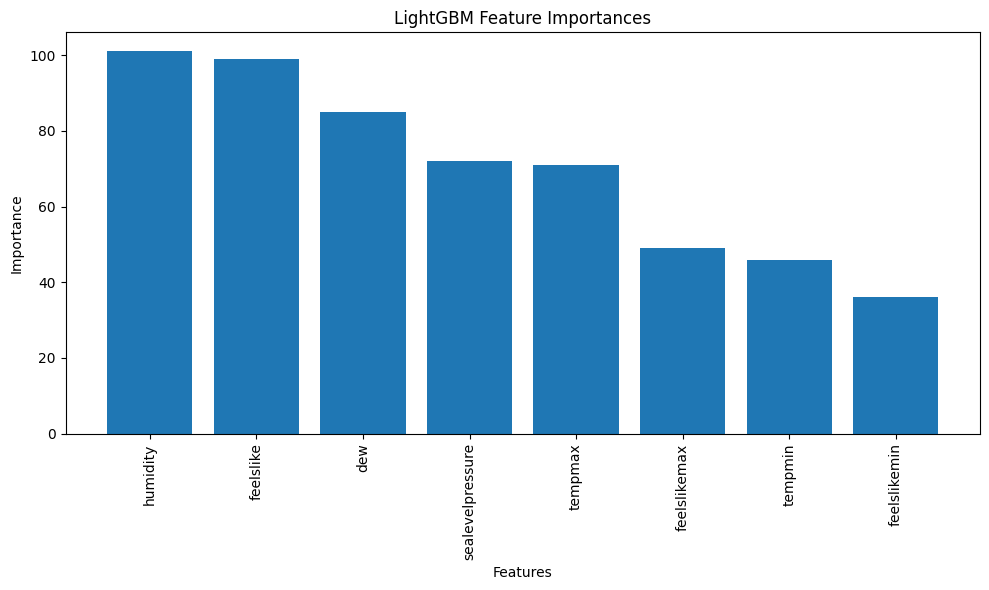

In [84]:
if type(best_model).__name__ == "LGBMRegressor":
    # Get feature importances
    feature_importances = best_model.feature_importances_
    
    # Get feature names (assuming X_train.columns contains your feature names)
    feature_names = X_train.columns.tolist()
    
    # Create a list of tuples with feature names and their importance scores
    feature_importance_pairs = list(zip(feature_names, feature_importances))
    
    # Sort the pairs by importance score in descending order
    sorted_importances = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
    
    print('\nFeatures and importance scores:')
    for name, importance in sorted_importances:
        print(f"{name}: {importance:.4f}")

    # Optionally, you can create a bar plot of feature importances
    plt.figure(figsize=(10, 6))
    plt.bar([x[0] for x in sorted_importances], [x[1] for x in sorted_importances])
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('LightGBM Feature Importances')
    plt.tight_layout()
    plt.show()

## **7.3 Run on test data**

In [85]:
#%% 7.3 Run on test data
try:
    num_pipeline = joblib.load(r'models/num_pipeline.pkl')
except FileNotFoundError:
    print("Error: num_pipeline.pkl file not found. Make sure you have saved the pipeline.")
    # Nếu không tìm thấy file, bạn có thể cần phải tạo và lưu pipeline trước

processed_test_set = num_pipeline.transform(test_set)
# 7.3.1 Compute R2 score and root mean squared error
r2score, rmse = r2score_and_rmse(best_model, processed_test_set, y_test)
print('\nPerformance on test data:')
print('R2 score (on test data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 7.3.2 Predict labels for some test instances
print("\nTest data: \n", X_test.iloc[0:9])
print("\nPredictions: ", best_model.predict(processed_test_set[0:9]).round(decimals=1))
print("Labels:      ", list(y_test[0:9]),'\n')
print("\nProcessed: \n", processed_test_set)


Performance on test data:
R2 score (on test data, best=1): 0.9056101051629488
Root Mean Square Error:  1.6368653852409232

Test data: 
    feelslike   tempmax  feelslikemax   tempmin  feelslikemin       dew  \
0   1.531874  1.296318      1.403462  0.637695      0.376529  1.048752   
1   1.275963  0.775198      1.215943  1.041398      1.343747  1.065685   
2   0.213933 -0.065317      0.038739  0.637695      0.376529  0.794765   
3   0.329093  0.943301      0.872158  0.435844      0.215326  0.540777   
4   1.250372  1.111404      1.143019  1.041398      1.343747  0.913292   
5  -0.988848 -1.174797     -1.138464 -0.775264     -0.751891 -0.559836   
6  -0.758528 -0.737729     -0.867603 -0.573413     -0.590688 -0.255051   
7   0.789732  0.775198      0.955500  0.839546      0.537732  0.947157   
8  -1.001643 -0.670488     -0.825932 -1.421188     -1.267741 -2.083761   

   sealevelpressure  humidity  
0         -1.182361  0.053713  
1         -1.351989  0.567749  
2         -0.574529  1.109

/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### **Overall Insight from the Predictions vs. Labels Analysis**

The comparison between the predicted values and the actual labels shows a pattern of slight overestimation across most instances. While the differences between predicted and actual values are generally small, there are a few notable instances where the model significantly overestimates, indicating room for improvement.

#### **Key Observations**:

- **General Overestimation**: The model tends to predict values slightly higher than the actual labels. In 6 out of 9 instances, the model’s predictions are greater than the actual values. This suggests that the model may be biased towards overestimating the outcomes, which could be due to an overfitting tendency on higher values in the training data.

- **Small Errors in Most Cases**: Despite the overestimation, the majority of the differences between the predicted and actual values are relatively small, typically within a range of 0.3 to 1.6. This indicates that the model is generally performing well and is capable of making fairly accurate predictions in most cases.

- **Significant Overestimation in Some Cases**: In certain cases, such as Instance 5, the model's overestimation is more pronounced, with a difference of +3.2. This suggests that the model might be struggling with specific conditions or features in the data that cause it to predict higher values than expected. It could benefit from fine-tuning or retraining with additional data to improve performance on these outliers.

- **Close Performance on Several Instances**: In instances like Instance 2, where the difference is only 0.3, the model demonstrates that it is capable of making very accurate predictions. This shows promise for the model’s overall robustness.

---

### **Enhanced Improvement Areas for Model Performance**

Building upon the initial insights from the comparison between predictions and labels, it's clear that while the model demonstrates commendable accuracy in several instances, there are specific areas where targeted improvements can significantly enhance its overall performance. Below are detailed recommendations to address the identified issues and further optimize the model:

---

#### **1. Addressing the Overestimation Bias**

**Issue Identified**: The model exhibits a tendency to slightly overestimate the actual values in the majority of instances.

**Improvement Strategies**:

- **Adjust the Loss Function**:
  - **Use Asymmetric Loss Functions**: Implement loss functions that penalize overestimation more heavily than underestimation. For example, Quantile Loss can be tailored to reduce bias in predictions.
  - **Custom Loss Functions**: Design a custom loss function that incorporates penalties for overestimation, encouraging the model to balance its predictions more effectively.

- **Regularization Techniques**:
  - **L1 and L2 Regularization**: Apply regularization to reduce model complexity and prevent overfitting, which can contribute to biased predictions.
  - **Elastic Net**: Combine L1 and L2 regularization to leverage the benefits of both methods, promoting sparsity and reducing variance.

- **Bias Correction Post-Processing**:
  - **Calibration Techniques**: Implement calibration methods such as Platt Scaling or Isotonic Regression to adjust the model's output probabilities and reduce bias.
  - **Scaling Predictions**: Apply a scaling factor to the predictions based on the observed bias to bring them closer to the actual values.

---

#### **2. Enhancing Model Robustness on Outliers**

**Issue Identified**: Significant overestimation in specific instances (e.g., Instance 5) indicates the model struggles with certain outliers or edge cases.

**Improvement Strategies**:

- **Robust Training Data**:
  - **Augment Training Data**: Incorporate more samples similar to the outliers to help the model learn from these scenarios.
  - **Synthetic Data Generation**: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic samples that represent underrepresented cases.

- **Advanced Feature Engineering**:
  - **Interaction Features**: Create interaction terms between features that might influence outlier behavior.
  - **Polynomial Features**: Incorporate polynomial features to capture non-linear relationships that may be causing the model to mispredict outliers.

- **Model Ensemble Techniques**:
  - **Stacking**: Combine multiple models to leverage their strengths and mitigate individual weaknesses, improving performance on outliers.
  - **Boosting**: Use ensemble methods like XGBoost or LightGBM that focus on correcting the errors of previous models, enhancing robustness against outliers.

- **Anomaly Detection Preprocessing**:
  - **Detect and Handle Outliers**: Implement anomaly detection algorithms (e.g., Isolation Forest, DBSCAN) to identify and appropriately handle outliers before training, either by removing them or treating them differently.

---

#### **3. Optimizing Feature Selection and Engineering**

**Issue Identified**: Potential room for improvement in the features used for model training, which can impact prediction accuracy.

**Improvement Strategies**:

- **Feature Importance Analysis**:
  - **Utilize Feature Importance Metrics**: Leverage model-based feature importance (e.g., from Random Forests, XGBoost) to identify and retain the most impactful features.
  - **Recursive Feature Elimination (RFE)**: Systematically remove less important features to enhance model performance and reduce overfitting.

- **Dimensionality Reduction**:
  - **Principal Component Analysis (PCA)**: Apply PCA to reduce feature dimensionality while preserving variance, potentially improving model efficiency and performance.
  - **t-Distributed Stochastic Neighbor Embedding (t-SNE)**: Use t-SNE for visualizing high-dimensional data, aiding in better feature engineering decisions.

- **Feature Scaling and Transformation**:
  - **Standardization**: Ensure all features are on a comparable scale using StandardScaler or MinMaxScaler, which can improve model convergence and performance.
  - **Log Transformation**: Apply log transformations to skewed features to stabilize variance and make the data more normal distribution-like.

- **Incorporate Domain Knowledge**:
  - **Create Domain-Specific Features**: Utilize insights from domain experts to engineer features that capture essential patterns and relationships relevant to the prediction task.
